In [ ]:
!pip -qq install simpletransformers

In [ ]:
#model paths
tbert="/content/drive/MyDrive/Models/Tamil/tbert_tamil.sav"
mabert="/content/drive/MyDrive/Models/Malayalam/mabert_malayalam.sav"
kbert="/content/drive/MyDrive/Models/Kannada/kbert_kannada.sav"

In [ ]:
import pickle
# load the model from disk
tbert_model = pickle.load(open(tbert, 'rb'))
mabert_model =pickle.load(open(mabert,'rb'))
kbert_model=pickle.load(open(kbert,'rb'))

## Preprocessing the dataset (text to numerical feature vector)

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from IPython.display import clear_output
def preprocess_dataset(file_path,model,training,n=None):
  df=pd.read_csv(file_path)
  processed_text,labels=[],[]
  if training:
    df=df.head(n)
  else:
    df=df.head(int(n*0.20)) #20% for testing
  for text,label in zip(df['text'],df['label']):
    labels.append(label)
    processed_text.append(model.predict([text])[1][0]) #processed text
    clear_output()
  return np.array(processed_text),np.array(labels)

### Ensemble models for kannada text

In [ ]:
 #get the features vector and their labels (training set)
X_train,y_train=preprocess_dataset("/content/drive/MyDrive/Preprocessed/kannada_dataset_1_train.csv",
                                   model=kbert_model,
                                   training=True,
                                   n=1000)

In [ ]:
#get the features vector and their labels (testing set)
X_test,y_test=preprocess_dataset("/content/drive/MyDrive/Preprocessed/kannada_dataset_1_train.csv",
                                 model=tbert_model,
                                 training=False,
                                 n=1000)

#### Decision tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix
clf=DecisionTreeClassifier(criterion='entropy',random_state=0)
clf.fit(X_train,y_train)
pred_dtc=clf.predict(X_test)
print(classification_report(pred_dtc,y_test))
print(confusion_matrix(pred_dtc,y_test))

              precision    recall  f1-score   support

           0       0.34      0.45      0.39        84
           1       0.25      0.20      0.22         5
           2       0.67      0.06      0.12        93
           3       0.12      0.12      0.12        16
           4       0.00      0.00      0.00         1
           5       0.02      1.00      0.04         1

    accuracy                           0.24       200
   macro avg       0.23      0.31      0.15       200
weighted avg       0.47      0.24      0.23       200

[[38  1  1  3  0 41]
 [ 2  1  0  0  1  1]
 [61  2  6 11  6  7]
 [ 9  0  2  2  0  3]
 [ 1  0  0  0  0  0]
 [ 0  0  0  0  0  1]]


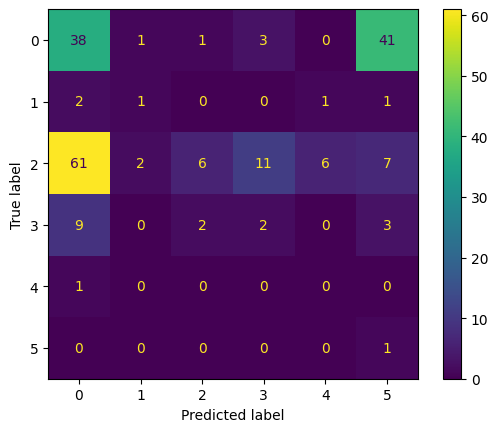

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
fig=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(pred_dtc,y_test),display_labels=clf.classes_)
fig.plot()

#### Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10,criterion='entropy',random_state=0)
rfc.fit(X_train,y_train)
pred_rfc = rfc.predict(X_test)
print(classification_report(y_test,pred_rfc))
print(confusion_matrix(y_test,pred_rfc))

              precision    recall  f1-score   support

           0       0.47      0.24      0.32       111
           1       0.00      0.00      0.00         4
           2       0.06      0.56      0.11         9
           3       0.17      0.06      0.09        16
           4       0.08      0.14      0.11         7
           5       0.61      0.36      0.45        53

    accuracy                           0.27       200
   macro avg       0.23      0.23      0.18       200
weighted avg       0.44      0.27      0.31       200

[[27  6 55  3  8 12]
 [ 1  0  2  1  0  0]
 [ 1  3  5  0  0  0]
 [ 2  3  9  1  1  0]
 [ 0  1  5  0  1  0]
 [26  1  4  1  2 19]]


In [ ]:
#find the best tree value
error_rate = []

for i in range(1,40):
    rfc = RandomForestClassifier(n_estimators=i,criterion='entropy',random_state=0)
    rfc.fit(X_train,y_train)
    pred_i = rfc.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

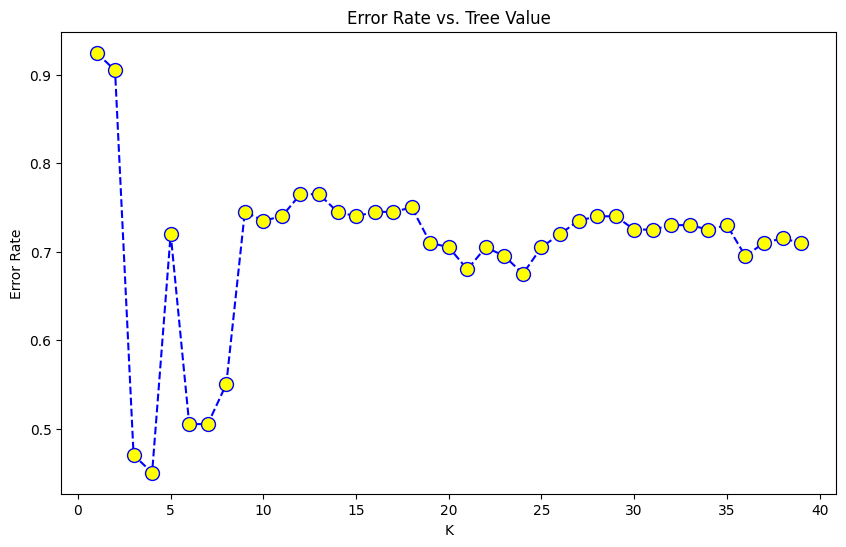

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='yellow', markersize=10)
plt.title('Error Rate vs. Tree Value')
plt.xlabel('K')
plt.ylabel('Error Rate') #error rate decrease as the tree value increases

In [ ]:
rfc = RandomForestClassifier(n_estimators=5,criterion='entropy',random_state=0) #12- trees from elbow method
rfc.fit(X_train,y_train)
pred_rfc= rfc.predict(X_test)
print(classification_report(y_test,pred_rfc))
print(confusion_matrix(y_test,pred_rfc))

              precision    recall  f1-score   support

           0       0.50      0.12      0.19       111
           1       0.00      0.00      0.00         4
           2       0.06      0.56      0.11         9
           3       0.20      0.06      0.10        16
           4       0.08      0.14      0.10         7
           5       0.58      0.68      0.63        53

    accuracy                           0.28       200
   macro avg       0.24      0.26      0.19       200
weighted avg       0.45      0.28      0.29       200

[[13  5 57  2  8 26]
 [ 1  0  2  1  0  0]
 [ 1  2  5  0  1  0]
 [ 2  2 10  1  1  0]
 [ 0  1  5  0  1  0]
 [ 9  1  4  1  2 36]]


#### Xgboost classifier

In [ ]:
!pip -qq install catboost xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.5 MB/s eta 0:00:00


In [ ]:
from xgboost import XGBClassifier
classifier=XGBClassifier()
classifier.fit(X_train,y_train)
pred_xgb= classifier.predict(X_test)
print(classification_report(y_test,pred_rfc))
print(confusion_matrix(y_test,pred_rfc))

              precision    recall  f1-score   support

           0       0.50      0.12      0.19       111
           1       0.00      0.00      0.00         4
           2       0.06      0.56      0.11         9
           3       0.20      0.06      0.10        16
           4       0.08      0.14      0.10         7
           5       0.58      0.68      0.63        53

    accuracy                           0.28       200
   macro avg       0.24      0.26      0.19       200
weighted avg       0.45      0.28      0.29       200

[[13  5 57  2  8 26]
 [ 1  0  2  1  0  0]
 [ 1  2  5  0  1  0]
 [ 2  2 10  1  1  0]
 [ 0  1  5  0  1  0]
 [ 9  1  4  1  2 36]]


#### Catboost classifier

In [ ]:
from catboost import CatBoostClassifier
classifier=CatBoostClassifier()
classifier.fit(X_train,y_train)
pred_xgb= classifier.predict(X_test)
print(classification_report(y_test,pred_rfc))
print(confusion_matrix(y_test,pred_rfc))

Learning rate set to 0.079127
0:	learn: 1.5431294	total: 72.3ms	remaining: 1m 12s
1:	learn: 1.3770558	total: 88.8ms	remaining: 44.3s
2:	learn: 1.2484017	total: 113ms	remaining: 37.6s
3:	learn: 1.1468123	total: 128ms	remaining: 31.8s
4:	learn: 1.0613011	total: 179ms	remaining: 35.6s
5:	learn: 0.9915586	total: 202ms	remaining: 33.4s
6:	learn: 0.9317405	total: 221ms	remaining: 31.3s
7:	learn: 0.8799179	total: 235ms	remaining: 29.1s
8:	learn: 0.8337624	total: 257ms	remaining: 28.3s
9:	learn: 0.7954066	total: 277ms	remaining: 27.4s
10:	learn: 0.7585756	total: 298ms	remaining: 26.8s
11:	learn: 0.7270912	total: 312ms	remaining: 25.7s
12:	learn: 0.6992081	total: 333ms	remaining: 25.3s
13:	learn: 0.6763027	total: 356ms	remaining: 25.1s
14:	learn: 0.6551962	total: 377ms	remaining: 24.7s
15:	learn: 0.6350611	total: 399ms	remaining: 24.6s
16:	learn: 0.6174710	total: 418ms	remaining: 24.2s
17:	learn: 0.6015766	total: 456ms	remaining: 24.9s
18:	learn: 0.5872301	total: 481ms	remaining: 24.8s
19:	lear